# Задание 3

In [96]:
!pip install -q catalyst

In [97]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [98]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.randn((1), ))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias
        return x

In [99]:
lr = LinearRegression(3, 3)
it = lr.parameters()
next(it), next(it)

(Parameter containing:
 tensor([[ 0.3367,  0.1288,  0.2345],
         [ 0.2303, -1.1229, -0.1863],
         [ 2.2082, -0.6380,  0.4617]], requires_grad=True),
 Parameter containing:
 tensor([0.2674], requires_grad=True))

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [100]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

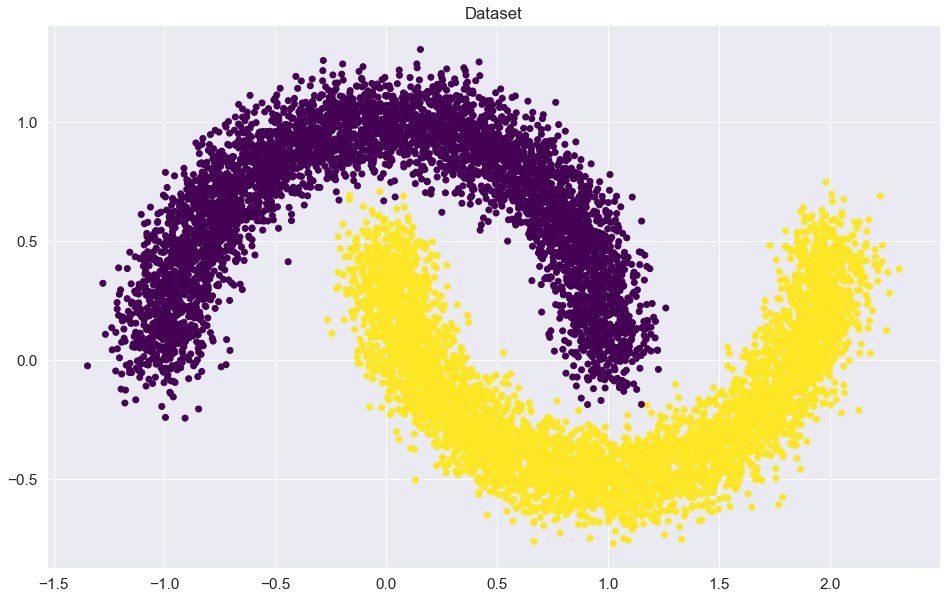

In [101]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [103]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [104]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [105]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
pars = linear_regression.parameters()
print(next(pars), next(pars))
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Parameter containing:
tensor([[0.3367],
        [0.1288]], requires_grad=True) Parameter containing:
tensor([0.2345], requires_grad=True)


In [106]:
import inspect
inspect.getclasstree((nn.BCEWithLogitsLoss,))

[(torch.nn.modules.loss._Loss, (torch.nn.modules.module.Module,)),
 [(torch.nn.modules.loss.BCEWithLogitsLoss, (torch.nn.modules.loss._Loss,))]]

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [107]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        loss = loss_function.forward(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = nn.Sigmoid().forward(outp)
        # print(probabilities[:10])
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    print(it)
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
58
Iteration: 7500
Batch accuracy: 0.765625
58
Iteration: 15000
Batch accuracy: 0.7890625
58
Iteration: 22500
Batch accuracy: 0.7890625
58
Iteration: 30000
Batch accuracy: 0.8046875
58
Iteration: 37500
Batch accuracy: 0.8046875
58
Iteration: 45000
Batch accuracy: 0.8046875
58
Iteration: 52500
Batch accuracy: 0.8203125
58
Iteration: 60000
Batch accuracy: 0.8203125
58
Iteration: 67500
Batch accuracy: 0.8203125
58
Iteration: 75000
Batch accuracy: 0.8203125
58
Iteration: 82500
Batch accuracy: 0.8203125
58
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90047.Convergence. Stopping iterations.
47


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

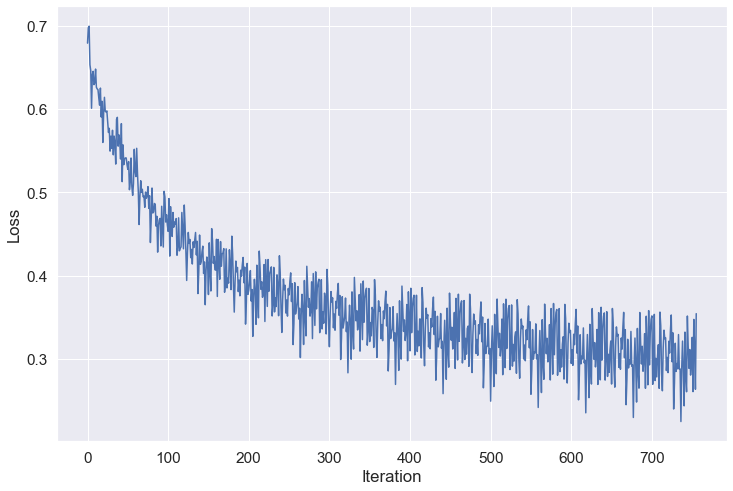

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

(400, 250)


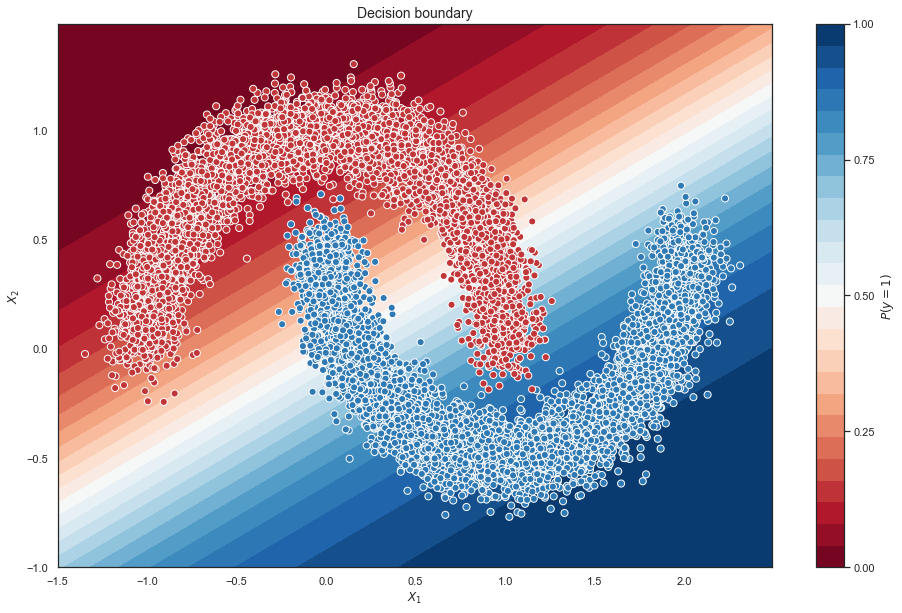

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
print(xx.shape)
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val, preds)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

### MNIST

In [24]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
print(train_dataset)
print(val_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ak/yd/cs/dlfall/04pytorch
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/ak/yd/cs/dlfall/04pytorch
    Split: Test


In [25]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape
x_batch.dtype

torch.uint8

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [27]:
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}
next(iter(loaders.values()))

      ### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.

```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [29]:
d 
  evicez
/= "cuda" if torch.cuda.is_available() else "cpu"

In [52]:
def run():
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        epoch_correct = 0
        epoch_all = 0
        utils.set_global_seed(42 + epoch)
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                # print(x_batch.unique())
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model.forward(x_batch.type(torch.float32))
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    par1 = list(model.parameters())[0].grad
                    nonnul = (par1 == 0).sum()
                    # print(nonnul)
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model.forward(x_batch.type(torch.float32))

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']



In [53]:
import copy
loaders = {"train": train_dataloader, "valid": valid_dataloader}

acc = {}
activations = [nn.ELU, nn.ReLU, nn.LeakyReLU, nn.Sequential]
names = ['elu', 'relu', 'leakyrelu', 'plain']
for name, activation in zip(names, activations):
    print(name, activation)
    model = nn.Sequential(
        Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    acc[name] = run()

elu <class 'torch.nn.modules.activation.ELU'>
Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1
Loader: train. Accuracy: 0.9011833333333333
Loader: valid. Accuracy: 0.9066
Epoch: 2
Loader: train. Accuracy: 0.9564333333333334
Loader: valid. Accuracy: 0.9570142857142857
Epoch: 3
Loader: train. Accuracy: 0.9668
Loader: valid. Accuracy: 0.9658857142857142
Epoch: 4
Loader: train. Accuracy: 0.9713666666666667
Loader: valid. Accuracy: 0.9662285714285714
Epoch: 5
Loader: train. Accuracy: 0.9735333333333334
Loader: valid. Accuracy: 0.9719857142857142
Epoch: 6
Loader: train. Accuracy: 0.9772666666666666
Loader: valid. Accuracy: 0.9750142857142857
Epoch: 7
Loader: train. Accuracy: 0.9775166666666667
Loader: valid. Accuracy: 0.9733
Epoch: 8
Loader: train. Accuracy: 0.9801833333333333
Load

Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [54]:
print(acc['relu'][:10])
print(acc['elu'][:10])

[0.9072, 0.9556142857142857, 0.9624571428571429, 0.9663428571428572, 0.9685857142857143, 0.9752857142857143, 0.9776, 0.9755857142857143, 0.9785, 0.9794285714285714]
[0.9066, 0.9570142857142857, 0.9658857142857142, 0.9662285714285714, 0.9719857142857142, 0.9750142857142857, 0.9733, 0.9781285714285715, 0.9776857142857143, 0.9788571428571429]


### Accuracy

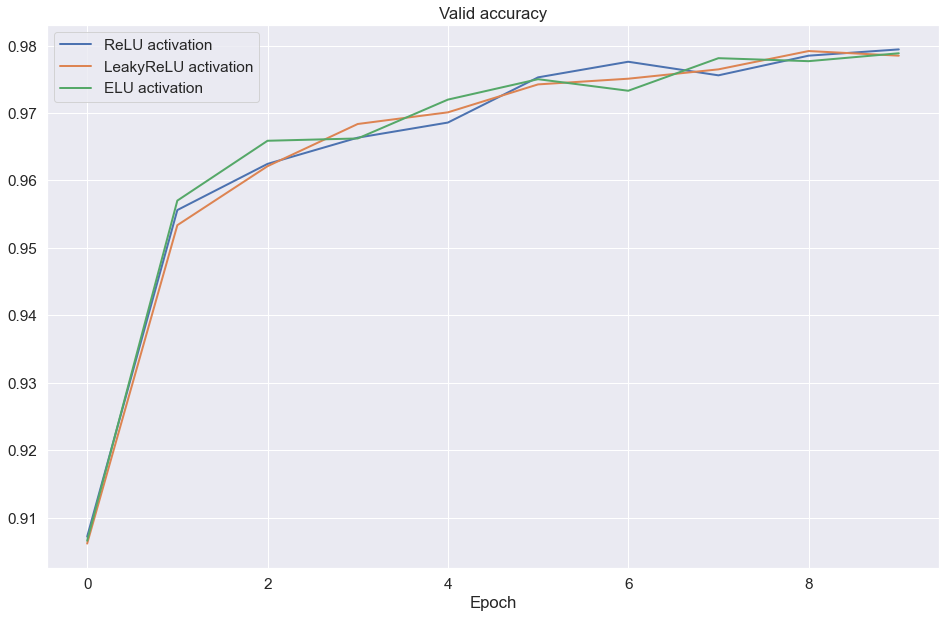

In [56]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
# plt.plot(range(max_epochs), acc['plain'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), acc['relu'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), acc['leakyrelu'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), acc['elu'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

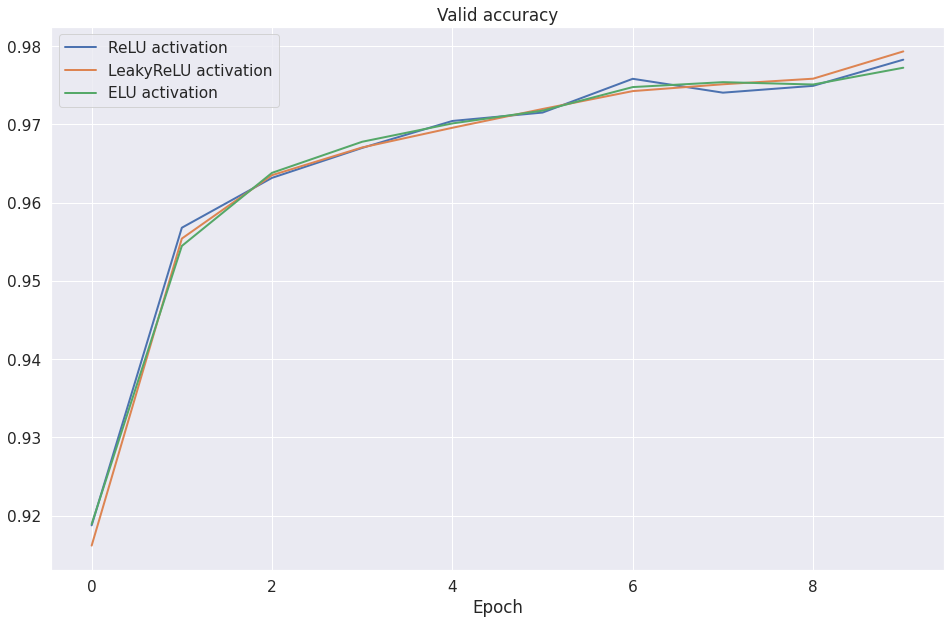

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:**

## Сверточные слои

### Ядра

In [48]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2020-11-12 03:23:45--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    in 0,1s    

2020-11-12 03:23:45 (496 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



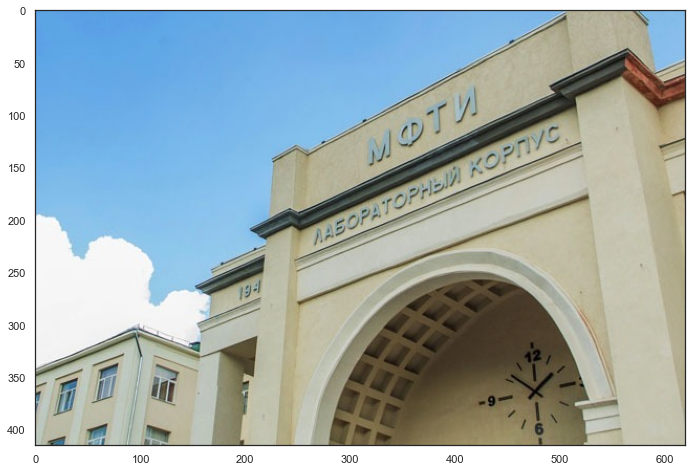

In [3]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [60]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'А': [[0, 0, 0], [0, 1, 0], [0, 0, 0]], 'Б': [[0, 0, 0], [1, -2, 1], [0, 0, 0]], 'В': [[0, 0, 0], [1, -2, 1], [0, 0, 0]], 'Г': [[0, 1, 0], [1, -4, 1], [0, 1, 0]], 'Д': [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], 'Е': [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]}
А tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]]) AxesSubplot(0.125,0.772143;0.775x0.107857)
Б tensor([[[[ 0.,  0.,  0.],
          [ 1., -2.,  1.],
          [ 0.,  0.,  0.]]]]) AxesSubplot(0.125,0.642714;0.775x0.107857)
В tensor([[[[ 0.,  0.,  0.],
          [ 1., -2.,  1.],
          [ 0.,  0.,  0.]]]]) AxesSubplot(0.125,0.513286;0.775x0.107857)
Г tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]]) AxesSubplot(0.125,0.383857;0.775x0.107857)
Д tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]]) AxesSubplot(0.125,0.254429;0.775x0.107857)
Е tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
   

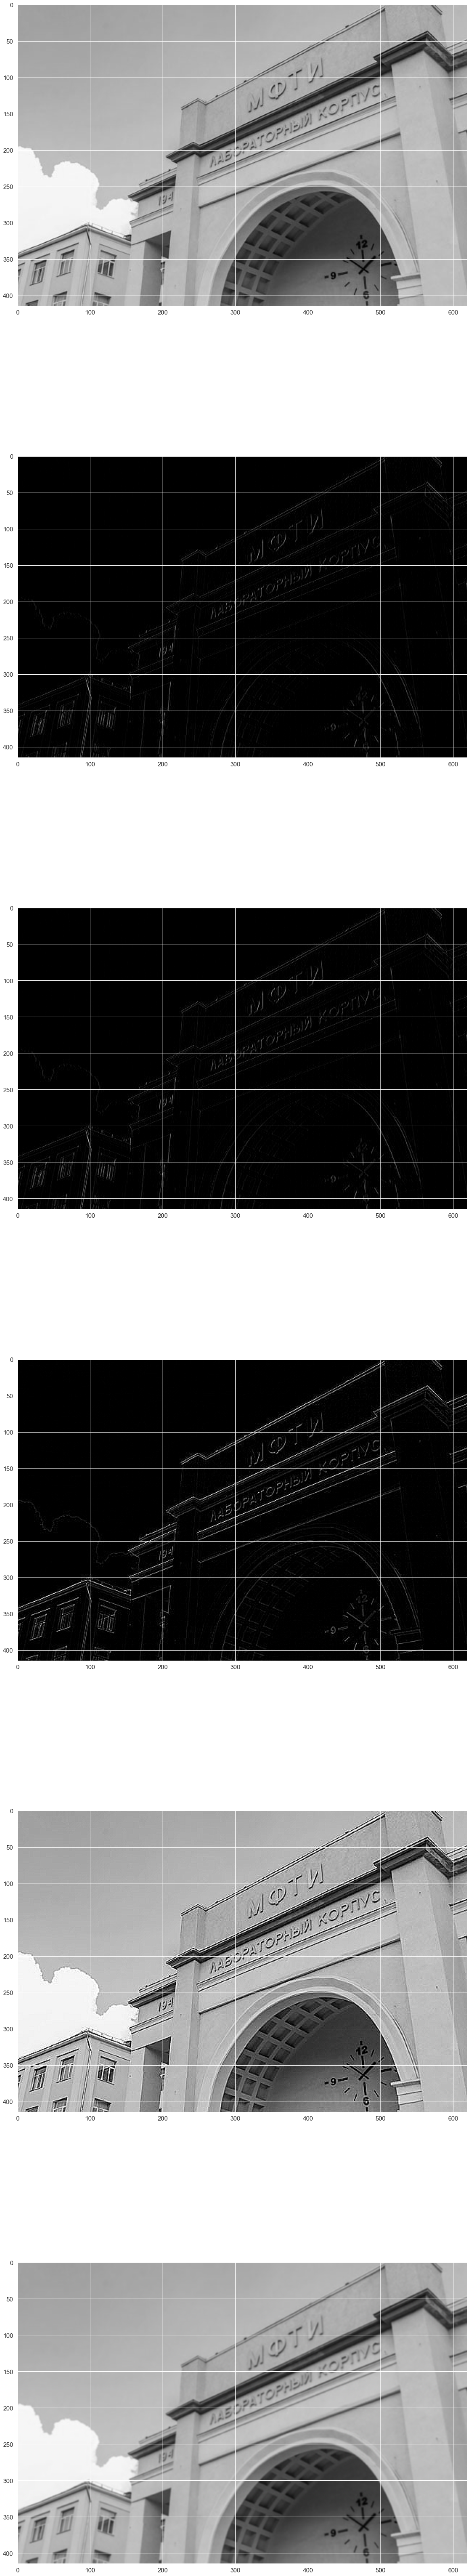

In [62]:
fig, axs = plt.subplots(6, 1, figsize=(20, 20*6))
kernels = {
'А': [[0, 0, 0],
 [0, 1, 0],
 [0, 0, 0]],
'Б': [[0, 0, 0],
 [1, -2, 1],
 [0, 0, 0]],
'В': [[0, 0, 0],
 [1, -2, 1],
 [0, 0, 0]],
'Г': [[0, 1, 0],
[1, -4, 1],
[0, 1, 0]],
'Д': [[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]],
'Е': [[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]]}
print(kernels)
for idx, ax in zip(kernels, axs.flatten()):
    kernel = torch.Tensor(kernels[idx]).reshape(1, 1, 3, 3).type(torch.float32)

    print(idx, kernel, ax)
    kernel = kernel.repeat(3, 3, 1, 1)

    result = F.conv2d(img_t, kernel)[0]  #
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    ax.imshow(result_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


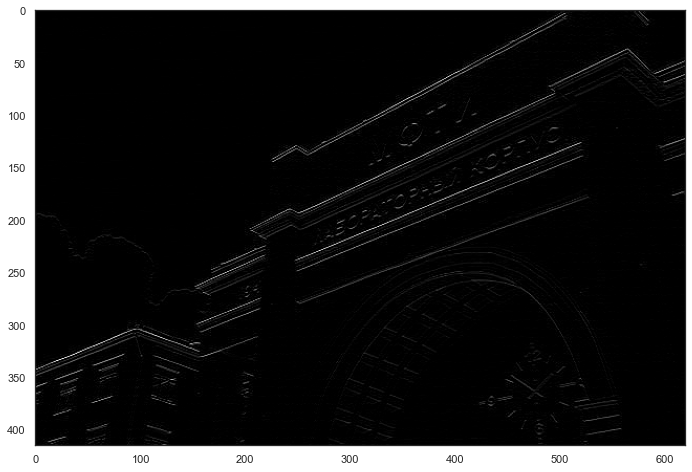

In [5]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [64]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
print(train_dataset)
print(val_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ak/yd/cs/dlfall/04pytorch
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/ak/yd/cs/dlfall/04pytorch
    Split: Test


In [65]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [67]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                # print(x_batch.unsqueeze(1).shape)
                outp = model.forward(x_batch.type(torch.float32).unsqueeze(1))
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.type(torch.float32).unsqueeze(1))
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            # if k == "train":
                # loss = criterion(outp, y_batch)
                 # YOUR CODE GOES HERE
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.93825
Loader: valid. Accuracy: 0.9422142857142857
Epoch: 2
Loader: train. Accuracy: 0.9797333333333333
Loader: valid. Accuracy: 0.9798857142857142
Epoch: 3
Loader: train. Accuracy: 0.9859666666666667
Loader: valid. Accuracy: 0.9858142857142858
Epoch: 4
Loader: train. Accuracy: 0.9892666666666666
Loader: valid. Accuracy: 0.9888285714285714
Epoch: 5
Loader: train. Accuracy: 0.9897833333333333
Loader: valid. Accuracy: 0.9887285714285714
Epoch: 6
Loader: train. Accuracy: 0.9917666666666667
Loader: valid. Accuracy: 0.9907714285714285
Epoch: 7
Loader: train. Accuracy: 0.9932833333333333
Loader: valid. Accuracy: 0.9922142857142857
Epoch: 8
Loader: train. Accuracy: 0.9940666666666667
Loader: valid. Accuracy: 0.9930428571428571
Epoch: 9
Loader: train. Accuracy: 0.99515
Loader: valid. Accuracy: 0.9934714285714286
Epoch: 10
Loader: train. Accuracy: 0.9934333333333333
Loader: valid. Accuracy: 0.9922857142857143


In [68]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

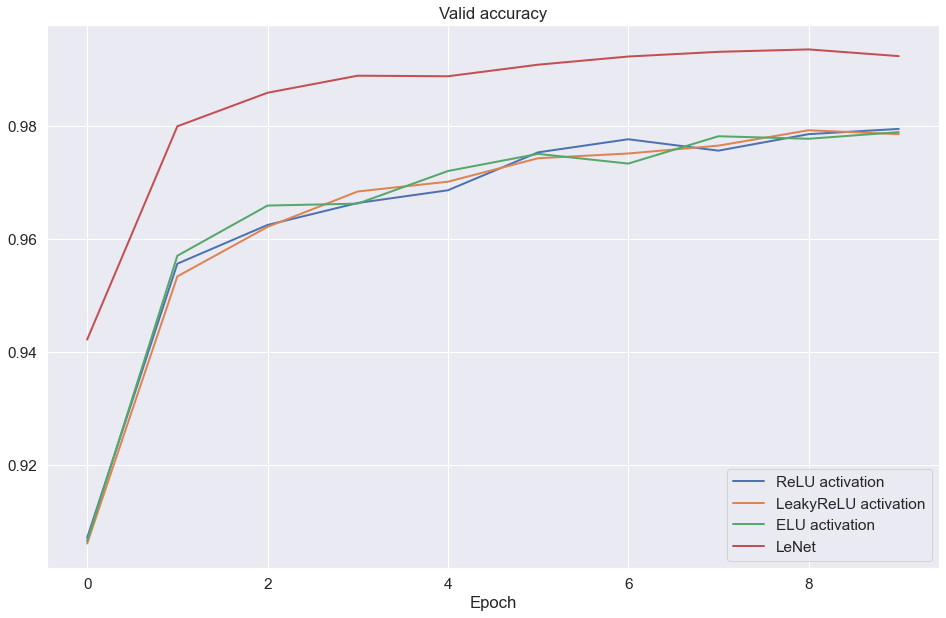

In [69]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), acc['relu'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), acc['leakyrelu'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), acc['elu'], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [94]:
y_pred = np.array([])
y_val = np.array([])
for x_batch, y_batch in valid_dataloader:
    with torch.no_grad():
        outp = model.forward(x_batch.type(torch.float32).unsqueeze(1))
        outp = nn.Softmax(outp)
        outp = outp.dim.numpy().argmax(axis=-1)
        y_pred = np.hstack((y_pred, outp))
        y_val = np.hstack((y_val, y_batch))

import sklearn
sklearn.metrics.accuracy_score(y_val, y_pred)

0.9854